In [68]:
import os
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
import seaborn as sns

import cv2

from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix


from tqdm import tqdm
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [47]:
data = '/kaggle/input/brain-tumor-mri-dataset/Training'
categories = ['glioma','meningioma','notumor','pituitary']

In [48]:
folds = [os.path.join(data, catg) for catg in categories]
folds

['/kaggle/input/brain-tumor-mri-dataset/Training/glioma',
 '/kaggle/input/brain-tumor-mri-dataset/Training/meningioma',
 '/kaggle/input/brain-tumor-mri-dataset/Training/notumor',
 '/kaggle/input/brain-tumor-mri-dataset/Training/pituitary']

In [49]:
for fold in folds:
    print(fold.split('/')[5], ':' ,len(os.listdir(fold)))

glioma : 1321
meningioma : 1339
notumor : 1595
pituitary : 1457


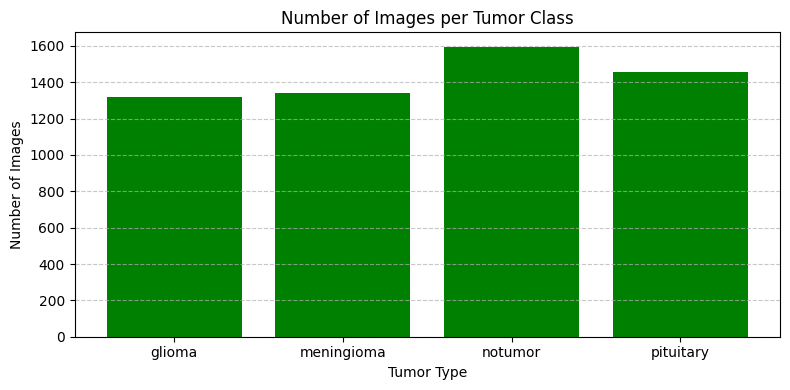

In [50]:
# Data extracted from output
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']
values = [1321, 1339, 1595, 1457]

plt.figure(figsize=(8, 4))
plt.bar(labels, values, color='green')
plt.title('Number of Images per Tumor Class')
plt.xlabel('Tumor Type')
plt.ylabel('Number of Images')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [51]:
def img_array_dim_all(folds, categories):
    for idx, folder in enumerate(folds):
        for img in os.listdir(folder):
            img_path = os.path.join(folder, img)
            img_array = cv2.imread(img_path)
            if img_array is not None:
                print(f"Category: {categories[idx]}")
                print(f"Dim: {img_array.shape}")
                print("-------------------")
                print(img_array)
                print("\n")
                break   # show only 1 sample per category

# Example usage
data = "/kaggle/input/brain-tumor-mri-dataset/Training"
categories = os.listdir(data)
folds = [os.path.join(data, catg) for catg in categories]

img_array_dim_all(folds, categories)

Category: pituitary
Dim: (512, 512, 3)
-------------------
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]


Category: notumor
Dim: (225, 225, 3)
-------------------
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]


Category: meningioma
Dim: (512, 512, 3)
------------

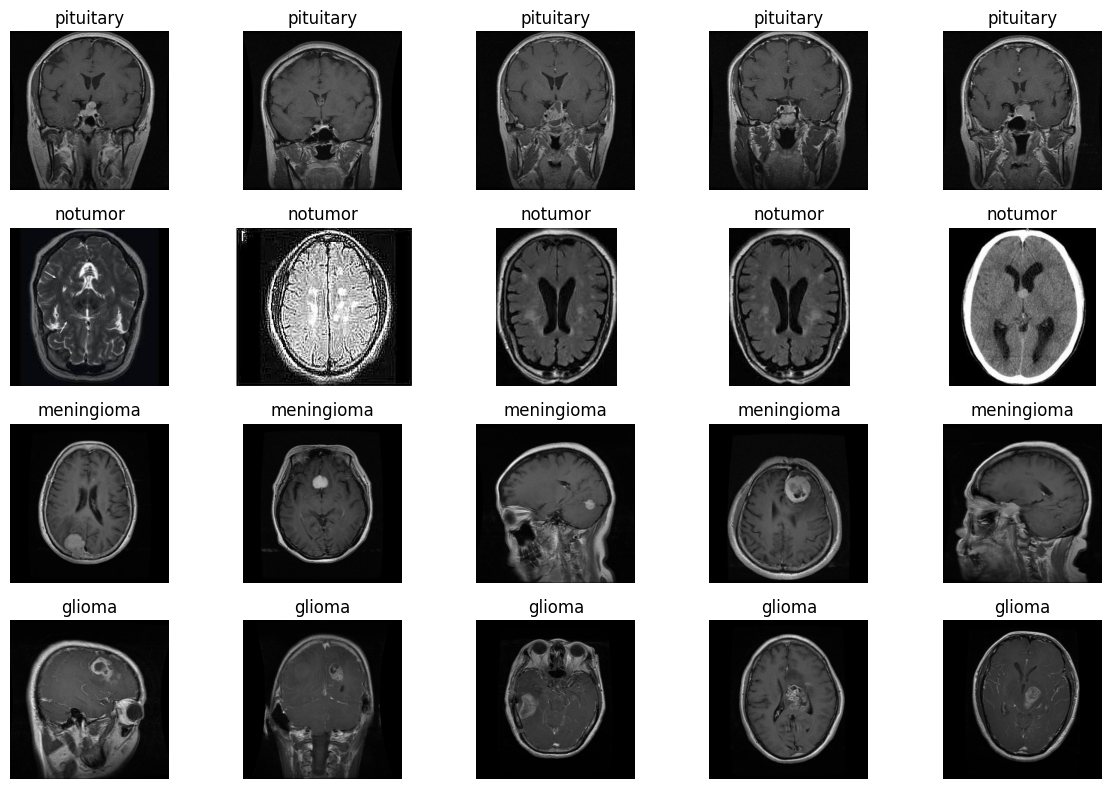

In [52]:
# Number of samples per category to display
samples_per_class = 5  

plt.figure(figsize=(12, 8))

# Loop through categories
for idx, category in enumerate(categories):
    folder_path = os.path.join(data, category)
    images = os.listdir(folder_path)
    
    # Pick random images from this category
    sample_imgs = random.sample(images, min(samples_per_class, len(images)))
    
    for i, img_name in enumerate(sample_imgs):
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Plot
        plt.subplot(len(categories), samples_per_class, idx*samples_per_class + i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(category)

plt.tight_layout()
plt.show()

In [53]:
# Load dataset
img_size = 128
X = []
y = []

for idx, category in enumerate(categories):
    folder = os.path.join(data, category)
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (img_size, img_size))
            X.append(img)
            y.append(idx)



In [54]:
X = np.array(X, dtype="float32") / 255.0
y = np.array(y)

In [55]:
# One-hot encode labels
y = to_categorical(y, num_classes=len(categories))

In [56]:
# Train/test split
x_train, x_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=y)

print("Training samples:", x_train.shape)
print("Testing samples:", x_test.shape)

Training samples: (4569, 128, 128, 3)
Testing samples: (1143, 128, 128, 3)


In [57]:
# Build CNN
model = Sequential()
model.add(Conv2D(32, (5,5), strides=(2,2), padding="same", input_shape=(img_size, img_size, 3)))
model.add(Activation("relu"))
model.add(Conv2D(32, (5,5), strides=(2,2)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(len(categories), activation="softmax"))

In [58]:
opt = RMSprop(learning_rate=0.0005)

model.compile(
    loss="categorical_crossentropy",
    optimizer=opt,
    metrics=["accuracy"]
)

In [59]:
## Check number of parameters

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 30, 30, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 7200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │     3,686,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,717,028 (14.18 MB)

 Trainable params: 3,717,028 (14.18 MB)

 Non-trainable params: 0 (0.00 B)

In [60]:
# Train
model.fit(
    x_train, 
    y_train, batch_size=32, 
    epochs=15, 
    validation_data=(x_test, y_test), 
    shuffle=True)

Epoch 1/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 26s 169ms/step - accuracy: 0.5455 - loss: 1.0300 - val_accuracy: 0.7349 - val_loss: 0.6124
Epoch 2/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 23s 160ms/step - accuracy: 0.7973 - loss: 0.5486 - val_accuracy: 0.8583 - val_loss: 0.4364
Epoch 3/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 26s 180ms/step - accuracy: 0.8424 - loss: 0.4380 - val_accuracy: 0.8399 - val_loss: 0.4208
Epoch 4/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 26s 180ms/step - accuracy: 0.8848 - loss: 0.3127 - val_accuracy: 0.8889 - val_loss: 0.2961
Epoch 5/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 23s 163ms/step - accuracy: 0.9058 - loss: 0.2598 - val_accuracy: 0.9055 - val_loss: 0.2523
Epoch 6/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 23s 161ms/step - accuracy: 0.9248 - loss: 0.2077 - val_accuracy: 0.9055 - val_loss: 0.2513
Epoch 7/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 23s 160ms/step - accuracy: 0.9397 - loss: 0.1712 - val_accuracy: 0.9221 - val_loss: 0.2353
Epoch 8/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 22s 157ms/step - accuracy: 0.9543 - loss: 0

In [61]:
# Evaluate
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9427 - loss: 0.2509
Test Accuracy: 0.9405


36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step
              precision    recall  f1-score   support

   pituitary       0.96      0.99      0.97       292
     notumor       0.97      0.97      0.97       319
  meningioma       0.87      0.90      0.89       268
      glioma       0.96      0.89      0.92       264

    accuracy                           0.94      1143
   macro avg       0.94      0.94      0.94      1143
weighted avg       0.94      0.94      0.94      1143



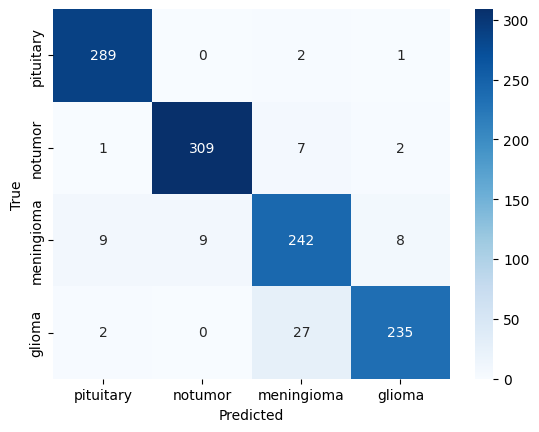

In [62]:
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred_classes, target_names=categories))

cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=categories, yticklabels=categories, cmap='Blues')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()


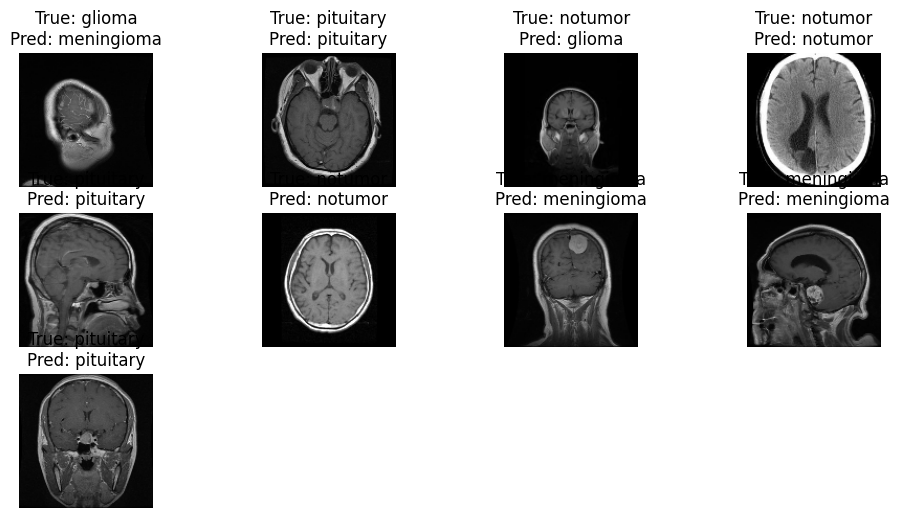

In [64]:
plt.figure(figsize=(12, 8))
for i in range(9):
    idx = np.random.randint(0, len(x_test))
    plt.subplot(4,4,i+1)
    plt.imshow(x_test[idx])
    plt.title(f"True: {categories[y_true[idx]]}\nPred: {categories[y_pred_classes[idx]]}")
    plt.axis("off")
plt.show()
